# Step 3 - Build Model


### Domain and Data

This project will be working with UCI's Madelon data set. The data is completly artifical, randomly labeled +1 or -1 with 500 features. Of these 500 features, 20 of them are "real" features and the remaining 480 are "probes" which add noise to the data. Of the 20 real features, there are 5 informative features, and the remaining 15 are linear combinations of the 5 informative features to add additional noise. The order of the features and patters were randomized.

### Problem Statement

Step 1 showed that logistic regression with no regularization predicts the labels of the data set with slightly better accuracy than a coin flip. Step 2 showed that logistic regression with a l1 norm and C=0.01 predicts the labels ~10% better than our benchmark. However, the l1 norm reduced the amount of features relevant to a single column, feature 241. Because  there are 5 "informative" features, a model which uses only 1 feature to predict the labels for this data set will not the most optimized.

### Solution Statement

This step will use feature selection: select K-best, logistic regression (with l1 norm), K Nearest Neighbors to predict the labels. Also, grid search will be used to hypertune the paramters of logistic regression and K Nearest Neighbors (as well as cross validate the set). 

### Metric

I will use the standard classifcation metric, "accuracy".  IE, what percentage did the model label the the data points correctly. I will Also look at false positives, and AUC as some deeper metrics to further provide some context as I make more complex models.

### Benchmark

My benchmark comes from Step 1 of this project, which creates a logistic regression model with no regularization or feature selection.

## Implementation

Implement the following code pipeline using the functions you write in `lib/project_5.py`.

<img src="assets/build_model.png" width="600px">

#### Select K Best Pipeline

In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from lib.project_5 import load_data_from_database, make_data_dict, general_transformer, general_model
import numpy as np

In [2]:
#preparing data for wrapper functions
data = load_data_from_database()
del data['index']
y = data['label']
del data['label']
X = data

In [3]:
#creating a data dictionary
data_dict = make_data_dict(X,y)

In [4]:
#standardizing the dictionary
data_dict_std = general_transformer(StandardScaler(),data_dict)

In [5]:
#select_k_best
from sklearn.feature_selection import SelectKBest
data_dict_std_selectK = general_transformer(SelectKBest(k=10),data_dict_std)

In [6]:
#look at k-best features (10 by default)
selectk_features = pd.DataFrame(data_dict_std_selectK['processes'][0].scores_,X.columns,columns=['scores'])
selectk_features.sort_values(['scores'],ascending = False).head(10)

,scores
feat_241,61.386110
feat_475,60.745620
feat_048,25.539078
feat_378,24.493360
feat_336,22.233552
feat_064,21.182336
feat_442,21.083091
feat_472,20.861572
feat_128,20.533043
feat_338,19.800707


The l1 norm regularized logistic regression showed that feat_241 was the strongest, and SelectKbest (which defaults to the ANOVA F-value to score the 10 best features) agrees with the l1 norm. However, select K best also has some other strong features (475,048...) which might provide useful in predicting the labels for each entry. 

#### Logistic Regression with GridSearch

In [7]:
from sklearn.model_selection import GridSearchCV

In [8]:
C = np.linspace(0.005,0.1,1000)
log_params = {'C' : C,
              'penalty':['l1','l2'],
             }

In [9]:
data_dict_std_selectK_log = general_model(GridSearchCV(LogisticRegression(),log_params,n_jobs=-1),data_dict_std_selectK)

In [10]:
data_dict_std_selectK_log['scores']

[0.61268656716417913, 0.6106060606060606]

In [22]:
data_dict_std_selectK_log['processes'][1].best_estimator_

LogisticRegression(C=0.020405405405405405, class_weight=None, dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l1', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False)

Training and test scores from gridsearched logistic regression model are similar to the l1 norm. This implies that perhaps logistic regression is not a strong candidate for this data set. Indeed, in the data set description, there are many non-linear features and logistic regression works best with linear features. This should provide motivation to use another model, such as KNN

In [11]:
from sklearn.metrics import confusion_matrix
confusion = confusion_matrix(data_dict_std_selectK_log['y_test'],data_dict_std_selectK_log['prediction'])

In [12]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="black" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix
[[ 0.6006192   0.3993808 ]
 [ 0.37982196  0.62017804]]


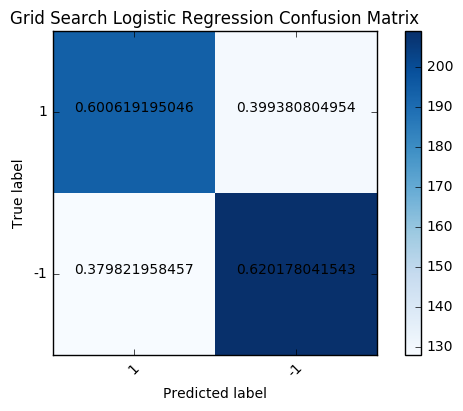

In [13]:
plot_confusion_matrix(confusion, classes=['1','-1'], normalize=True,
                      title='Grid Search Logistic Regression Confusion Matrix')
#plt.savefig('gridsearchlogistic.png', bbox_inches='tight')

In [14]:
#finding the area under the roc curve
from sklearn.metrics import roc_curve, auc
# roc_curve returns the false positive rate and true positive rates as the threshold changes
# takes in the y and the predicted probabilities of the positive class from your model.
fpr_lr, tpr_lr, _ = roc_curve(data_dict_std_selectK_log['y_test'],data_dict_std_selectK_log['prediction'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.61039861829473319

Area under the ROC is also similar to original l1 results. Same conclusion as above. Same for confusion matrix paramters 

#### KNN with gridsearch

In [15]:
from sklearn.neighbors import KNeighborsClassifier

In [16]:
n_neighbors = np.linspace(1,100,100)

In [17]:
knn_params = {'n_neighbors':n_neighbors,
              'weights' : ['uniform','distance']}


In [18]:
data_dict_std_selectK_KNN = general_model(GridSearchCV(KNeighborsClassifier(),knn_params,n_jobs=-1),data_dict_std_selectK)

/Users/Scott/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/Scott/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/Scott/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  return [func(*args, **kwargs) for func, args, kwargs in self.items]
/Users/Scott/anaconda/lib/python2.7/site-packages/sklearn/externals/joblib/parallel.py:131: VisibleDeprecationWarning: using a non-integer number instead of an integer will

In [19]:
data_dict_std_selectK['scores']

[1.0, 0.86969696969696975]

In [23]:
data_dict_std_selectK_KNN['processes'][2].best_estimator_

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=6.0, p=2,
           weights='distance')

In [25]:
fpr_lr, tpr_lr, _ = roc_curve(data_dict_std_selectK_KNN['y_test'],data_dict_std_selectK_KNN['prediction'])
roc_auc_lr = auc(fpr_lr, tpr_lr)
roc_auc_lr

0.87021708574105883

Normalized confusion matrix
[[ 0.89473684  0.10526316]
 [ 0.15430267  0.84569733]]


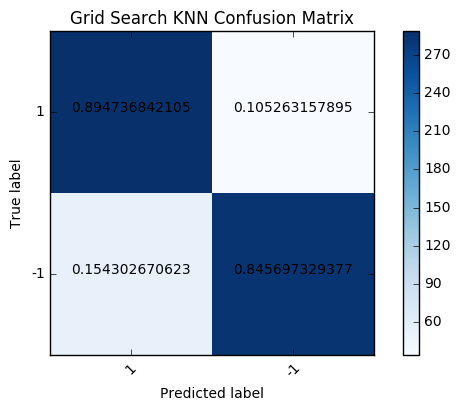

In [27]:
confusion = confusion_matrix(data_dict_std_selectK_KNN['y_test'],data_dict_std_selectK_KNN['prediction'])
plot_confusion_matrix(confusion, classes=['1','-1'], normalize=True,
                      title='Grid Search KNN Confusion Matrix')
plt.savefig('gridsearchKNN.png', bbox_inches='tight')

Training Score is perfect, and testing score is 0.87. These results are impressive, though I am worried about overfitting because of the perfect training score. Never the less, it seems KNN does much better than logistic regression. KNN has a 0.89 true positive rate and a 0.85 true negative rate, with an AUC of 0.87. 